In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import copy

import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
root_dir="/content/drive/MyDrive/datacov"
print(os.listdir(root_dir))

['train', 'val']


**Transfer Learning**





In [3]:
model=models.vgg16(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
model = models.vgg16(pretrained=True)
for param in model.parameters():
    param.requires_grad = False


In [5]:
model.classifier = nn.Sequential(
                        nn.Linear(25088, 512),
                        nn.Linear(512,64),
                        nn.Dropout(0.4),
                        nn.Linear(64,32),
                        nn.Dropout(0.4),
                        nn.Linear(32,2),
                        
                        
                                   )

In [7]:
data_transforms = {
    'train':transforms.Compose([
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val':transforms.Compose([transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

In [8]:
image_datasets = {x: datasets.ImageFolder(os.path.join(root_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
print(image_datasets)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes
print(class_names)

{'train': Dataset ImageFolder
    Number of datapoints: 2232
    Root location: /content/drive/MyDrive/datacov/train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               Resize(size=224, interpolation=bilinear)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'val': Dataset ImageFolder
    Number of datapoints: 249
    Root location: /content/drive/MyDrive/datacov/val
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )}
['covid', 'no_covid']


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 224, 224])


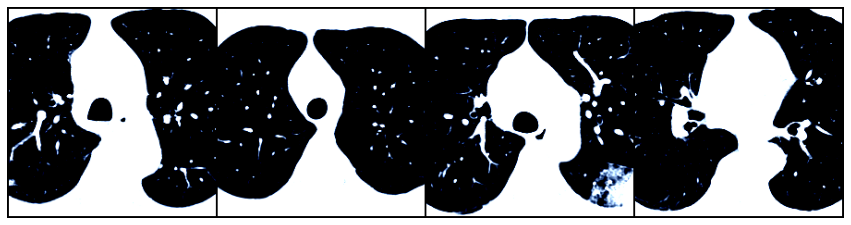

In [9]:
import matplotlib.pyplot as plt
def imshow(image):
    if isinstance(image, torch.Tensor):
        image = image.numpy().transpose((1, 2, 0))
    else:
        image = np.array(image).transpose((1, 2, 0))

    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    plt.imshow(image)
    ax.axis('off') 
        
images, _ = next(iter(dataloaders['train']))
print(images.shape)
out = torchvision.utils.make_grid(images, nrow=4)
imshow(out)
print(dataloaders['train'])

In [10]:
device = torch.device("cuda:0")

In [11]:

model = model.to(device)

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    global training_loss
    global valid_loss
    global valid_acc
    global training_acc
    training_loss=[]
    valid_loss=[]
    valid_acc=[]
    training_acc=[]

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs,1)
                    
                    
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()



            if phase=='train':
              training_loss.append(float(running_loss / dataset_sizes[phase]))
              training_acc.append(float(running_corrects.double() / dataset_sizes[phase])) 
            if phase=='val':
              valid_loss.append(float(running_loss / dataset_sizes[phase]))
              valid_acc.append(float(running_corrects.double() / dataset_sizes[phase]))


            epoch_loss= running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [13]:
criteria = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [14]:

model = train_model(model, criteria, optimizer, scheduler)

Epoch 0/4
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.4107 Acc: 0.8226
val Loss: 0.2012 Acc: 0.9197

Epoch 1/4
----------
train Loss: 0.2125 Acc: 0.9189
val Loss: 0.1597 Acc: 0.9398

Epoch 2/4
----------
train Loss: 0.1433 Acc: 0.9503
val Loss: 0.1483 Acc: 0.9598

Epoch 3/4
----------
train Loss: 0.0937 Acc: 0.9704
val Loss: 0.1475 Acc: 0.9639

Epoch 4/4
----------
train Loss: 0.0749 Acc: 0.9695
val Loss: 0.1520 Acc: 0.9639

Training complete in 5m 42s
Best val Acc: 0.963855


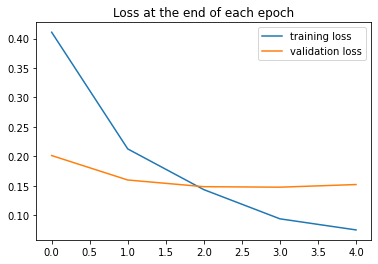

In [15]:

plt.plot(training_loss, label='training loss')
plt.plot(valid_loss, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

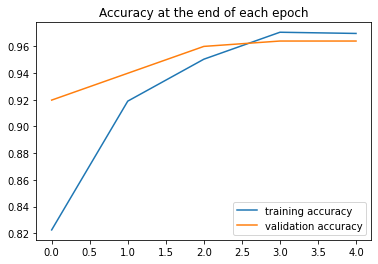

In [16]:
plt.plot(training_acc, label='training accuracy')
plt.plot(valid_acc, label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

class: 0


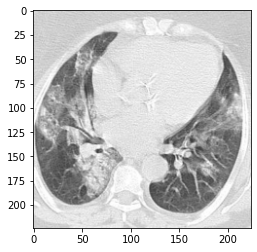

In [17]:
#Getting the image and its class
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
print('class: {}'.format(image_datasets['val'][1][1]))
im = inv_normalize(image_datasets['val'][1][0])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [18]:
#Predicting the class
model.eval()
with torch.no_grad():
    new_pred =model((image_datasets['val'][1][0].to(device)).view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

Predicted value: 0 covid
